In [1]:
# 1. Install standard libraries
!pip install awkward vector pytorch-lightning

# 2. Install vqtorch directly from GitHub
!pip install git+https://github.com/minyoungg/vqtorch.git

import torch
import vqtorch
print(f"vqtorch installed successfully.")
print(f"GPU Available: {torch.cuda.is_available()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.5/909.5 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 656.7/656.7 kB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 71.6 MB/s eta 0:00:00
  Cloning https://github.com/minyoungg/vqtorch.git to /tmp/pip-req-build-sw07mmr5
  Running command git clone --filter=blob:none --quiet https://github.com/minyoungg/vqtorch.git /tmp/pip-req-build-sw07mmr5
  Resolved https://github.com/minyoungg/vqtorch.git to commit 02e60a19bd742c17b0bf3e1925f23796d54cbeac
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.5 MB/s eta 0:00:00
  Created wheel for vqtorch: filename=vqtorch-0.1.0-py3-none-any.whl size=17825 sha256=32a2d88edf91a73eba8931c2b75160f74f2eb92f0b0e97d098453cfaea0b103b
  Stored in d

In [13]:
# ==========================================
# GENERATE "MEDIUM" DATASET (Energy + Shape)
# ==========================================
import torch
import numpy as np

def generate_medium_jets(num_jets=1000, num_particles=30):
    x = torch.zeros(num_jets, num_particles, 3)
    y = torch.zeros(num_jets)

    for i in range(num_jets):
        is_signal = i % 2 == 0

        if is_signal:
            y[i] = 1
            # Signal: Tight AND Higher Energy
            # Position: Narrow (0.1)
            eta = np.random.normal(0, 0.1, num_particles)
            phi = np.random.normal(0, 0.1, num_particles)
            # Energy: Mean = 60 (Higher)
            pt  = np.random.exponential(60, num_particles)
        else:
            y[i] = 0
            # Background: Wide AND Lower Energy
            # Position: Wide (0.6)
            eta = np.random.normal(0, 0.6, num_particles)
            phi = np.random.normal(0, 0.6, num_particles)
            # Energy: Mean = 40 (Lower, but overlaps with 60)
            pt  = np.random.exponential(40, num_particles)

        x[i, :, 0] = torch.tensor(pt)
        x[i, :, 1] = torch.tensor(eta)
        x[i, :, 2] = torch.tensor(phi)

    # Shuffle
    indices = torch.randperm(num_jets)
    return x[indices], y[indices]

# 1. Generate
x, y = generate_medium_jets()

# 2. Normalize (Crucial!)
# We use a global max to keep the relative difference between 60 and 40
max_pt = x[:, :, 0].max()
x[:, :, 0] = x[:, :, 0] / max_pt

x[:, :, 1] = x[:, :, 1] / 3.0
x[:, :, 2] = x[:, :, 2] / 3.0

print(f"Medium Data Generated! Max pT: {max_pt:.2f}")

Medium Data Generated! Max pT: 513.73


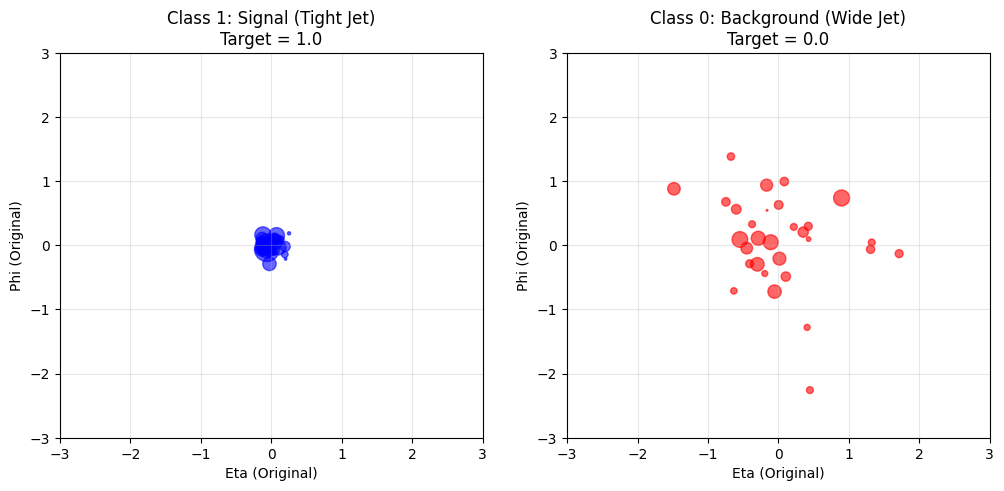

In [14]:
import matplotlib.pyplot as plt

# Find one signal and one background index
sig_idx = (y == 1).nonzero(as_tuple=True)[0][0]
bkg_idx = (y == 0).nonzero(as_tuple=True)[0][0]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ==========================================
# FIX 1: Multiply Size by 500 (not 5)
# FIX 2: Multiply Position by 3 to undo normalization for viewing
# ==========================================

# --- Plot Signal ---
# We multiply by 3 to show the "Physics Scale" again
ax[0].scatter(x[sig_idx,:,1]*3, x[sig_idx,:,2]*3,
              s=x[sig_idx,:,0]*500, # Scale size up to see energy
              alpha=0.6, c='blue')
ax[0].set_title(f"Class 1: Signal (Tight Jet)\nTarget = {y[sig_idx]}")
ax[0].set_xlim(-3, 3); ax[0].set_ylim(-3, 3)
ax[0].set_xlabel("Eta (Original)"); ax[0].set_ylabel("Phi (Original)")
ax[0].grid(True, alpha=0.3)

# --- Plot Background ---
ax[1].scatter(x[bkg_idx,:,1]*3, x[bkg_idx,:,2]*3,
              s=x[bkg_idx,:,0]*500, # Scale size up
              alpha=0.6, c='red')
ax[1].set_title(f"Class 0: Background (Wide Jet)\nTarget = {y[bkg_idx]}")
ax[1].set_xlim(-3, 3); ax[1].set_ylim(-3, 3)
ax[1].set_xlabel("Eta (Original)"); ax[1].set_ylabel("Phi (Original)")
ax[1].grid(True, alpha=0.3)

plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

# ==========================================
# 1. Define the "Deep Sets" Model
# ==========================================
class DeepSetsClassifier(nn.Module):
    def __init__(self, input_dim=3, latent_dim=64, output_dim=1):
        super(DeepSetsClassifier, self).__init__()

        # Phi Network: Looks at each particle individually
        # It learns "What does a single particle tell me?"
        self.phi = nn.Sequential(
            nn.Linear(input_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU()
        )

        # Rho Network: Looks at the summed "Jet Info"
        # It learns "What does the whole cloud look like?"
        self.rho = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, output_dim) # Output: 1 number (Score)
        )

    def forward(self, x):
        # x shape: [Batch, 30 Particles, 3 Features]

        # 1. Apply Phi to every particle
        # We process all particles at once using PyTorch magic
        particle_feats = self.phi(x)
        # Shape is now: [Batch, 30, 64]

        # 2. Aggregation (The "Sum" Step)
        # We sum across the particle dimension (dim=1)
        # This makes the model "Permutation Invariant"
        jet_feats = torch.mean(particle_feats, dim=1)
        # Shape is now: [Batch, 64] (One vector per jet)

        # 3. Apply Rho to classify the jet
        out = self.rho(jet_feats)
        return out

# ==========================================
# 2. Setup Training
# ==========================================
# Initialize the model
model = DeepSetsClassifier()

# Define Loss Function (Binary Cross Entropy)
# "BCEWithLogits" is more stable than standard BCE
criterion = nn.BCEWithLogitsLoss()

# Define Optimizer (Adam is the standard choice)
optimizer = optim.Adam(model.parameters(), lr=0.001)




# ==========================================
# PRE-PROCESSING FIX
# ==========================================

# 1. Normalize pT (Feature 0)
# We divide by the maximum value to squish it between 0 and 1
max_pt = x[:, :, 0].max()
x[:, :, 0] = x[:, :, 0] / max_pt

# 2. Normalize Eta/Phi (Features 1 and 2)
# We divide by 3 because we know they are usually within [-3, 3]
x[:, :, 1] = x[:, :, 1] / 3.0
x[:, :, 2] = x[:, :, 2] / 3.0

print(f"Data Normalized! Max pT is now: {x[:, :, 0].max().item():.2f}")

# Now re-run the split and training loop below...



# Split data into Train (800) and Test (200)
train_split = int(0.8 * len(x))
x_train, y_train = x[:train_split], y[:train_split].unsqueeze(1)
x_test,  y_test  = x[train_split:], y[train_split:].unsqueeze(1)

# ==========================================
# 3. The Training Loop
# ==========================================
print("Starting Training...")
print("-" * 30)

num_epochs = 80 # How many times to loop through the data

for epoch in range(num_epochs):
    model.train() # Set to training mode

    # Forward pass: Compute predictions
    outputs = model(x_train)

    # Calculate error (Loss)
    loss = criterion(outputs, y_train)

    # Backward pass: Update weights
    optimizer.zero_grad() # Reset gradients
    loss.backward()       # Calculate gradients
    optimizer.step()      # Update weights

    # Print progress every 5 epochs
    if (epoch+1) % 5 == 0:
        # Calculate Accuracy on Test Data
        model.eval() # Set to evaluation mode
        with torch.no_grad():
            test_outputs = model(x_test)
            predicted = (torch.sigmoid(test_outputs) > 0.5).float()
            accuracy = (predicted == y_test).float().mean()
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Accuracy: {accuracy.item()*100:.1f}%')

print("-" * 30)
print("Training Complete.")

Data Normalized! Max pT is now: 1.00
Starting Training...
------------------------------
Epoch [5/80], Loss: 0.6933, Test Accuracy: 50.0%
Epoch [10/80], Loss: 0.6928, Test Accuracy: 50.0%
Epoch [15/80], Loss: 0.6924, Test Accuracy: 50.0%
Epoch [20/80], Loss: 0.6919, Test Accuracy: 54.0%
Epoch [25/80], Loss: 0.6910, Test Accuracy: 85.0%
Epoch [30/80], Loss: 0.6895, Test Accuracy: 77.5%
Epoch [35/80], Loss: 0.6868, Test Accuracy: 83.5%
Epoch [40/80], Loss: 0.6824, Test Accuracy: 76.5%
Epoch [45/80], Loss: 0.6755, Test Accuracy: 79.5%
Epoch [50/80], Loss: 0.6643, Test Accuracy: 82.5%
Epoch [55/80], Loss: 0.6462, Test Accuracy: 87.0%
Epoch [60/80], Loss: 0.6194, Test Accuracy: 88.5%
Epoch [65/80], Loss: 0.5823, Test Accuracy: 89.0%
Epoch [70/80], Loss: 0.5334, Test Accuracy: 88.0%
Epoch [75/80], Loss: 0.4798, Test Accuracy: 92.5%
Epoch [80/80], Loss: 0.4232, Test Accuracy: 94.5%
------------------------------
Training Complete.


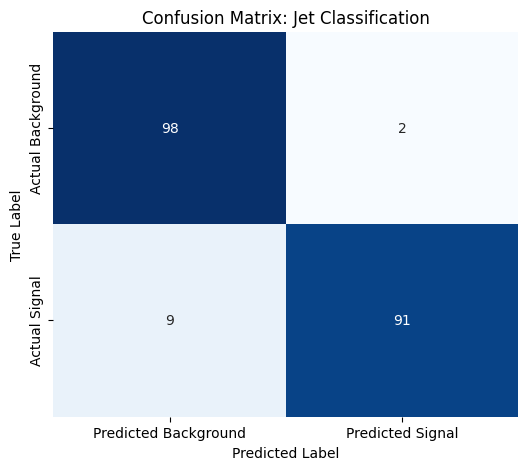

True Positives (Signal found): 91
False Positives (Background mistaken for Signal): 2
False Negatives (Signal missed): 9
True Negatives (Background rejected): 98
------------------------------
Precision (Purity): 0.98
Recall (Efficiency): 0.91


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get predictions on the Test Set
model.eval()
with torch.no_grad():
    # Get raw scores
    test_outputs = model(x_test)
    # Convert to 0 or 1 (Predictions)
    predicted = (torch.sigmoid(test_outputs) > 0.5).float().numpy()
    # Get true labels
    true_labels = y_test.numpy()

# 2. Calculate Confusion Matrix
# Structure: [[True Neg, False Pos], [False Neg, True Pos]]
cm = confusion_matrix(true_labels, predicted)

# 3. Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Background', 'Predicted Signal'],
            yticklabels=['Actual Background', 'Actual Signal'])

plt.title('Confusion Matrix: Jet Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Print detailed metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn) # Also called Sensitivity or Efficiency

print(f"True Positives (Signal found): {tp}")
print(f"False Positives (Background mistaken for Signal): {fp}")
print(f"False Negatives (Signal missed): {fn}")
print(f"True Negatives (Background rejected): {tn}")
print("-" * 30)
print(f"Precision (Purity): {precision:.2f}")
print(f"Recall (Efficiency): {recall:.2f}")

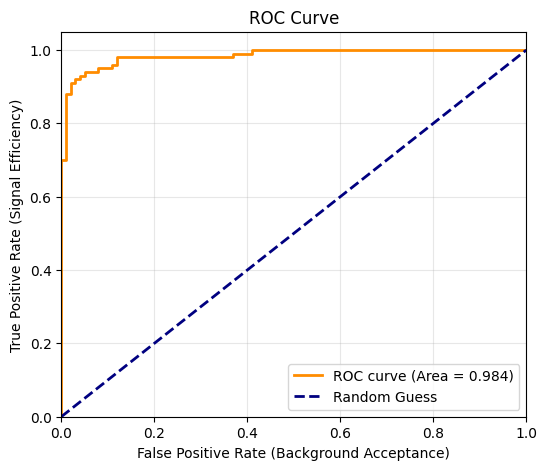

AUC Score: 0.9843


In [17]:
from sklearn.metrics import roc_curve, auc

# 1. Get probability scores (not just 0 or 1)
model.eval()
with torch.no_grad():
    raw_scores = model(x_test)
    probs = torch.sigmoid(raw_scores).numpy()
    true_labels = y_test.numpy()

# 2. Calculate ROC Data
fpr, tpr, thresholds = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)

# 3. Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (Area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Background Acceptance)')
plt.ylabel('True Positive Rate (Signal Efficiency)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

In [18]:
# Save the model's "state_dict" (the learned weights)
torch.save(model.state_dict(), "deep_sets_classifier_auc_98.pth")
print("Model saved successfully!")

# How to load it back later:
# new_model = BetterDeepSets()
# new_model.load_state_dict(torch.load("deep_sets_classifier_auc_98.pth"))

Model saved successfully!
